In [1]:
# --- Spark Bootstrap (Colab-safe) ---
# Java 17 + PySpark 3.5.x (works together)
!apt -qq update -y > /dev/null
!apt -qq install -y openjdk-17-jdk-headless > /dev/null
!pip -q install pyspark==3.5.1

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"   # avoid hostname resolution issues

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("colab-spark")
    # bind driver explicitly; prevents py4j 'connection refused'
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    # modest settings for Colab RAM
    .config("spark.sql.shuffle.partitions", "48")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.maxResultSize", "1g")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

print("Spark up ✔", spark.version, "| JAVA_HOME =", os.environ["JAVA_HOME"])




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Spark up ✔ 3.5.1 | JAVA_HOME = /usr/lib/jvm/java-17-openjdk-amd64


In [2]:
from pyspark.sql import functions as F
spark.range(5).withColumn("x2", F.col("id")*2).show()


+---+---+
| id| x2|
+---+---+
|  0|  0|
|  1|  2|
|  2|  4|
|  3|  6|
|  4|  8|
+---+---+



In [18]:
# Import PySpark and Matplotlib libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("LeetCodeDataset-EDA") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print("Spark Session is ready!")


Spark Session is ready!


In [22]:
from datasets import load_dataset
import numpy as np

# Load the Hugging Face dataset
dataset = load_dataset("newfacade/LeetCodeDataset", split="train")

# Convert to pandas DataFrame
dfpandas = dataset.to_pandas()

# Convert any numpy.ndarray columns (e.g., 'tags') to list
for col in dfpandas.columns:
    if isinstance(dfpandas[col].iloc[0], np.ndarray):
        dfpandas[col] = dfpandas[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Now create Spark DataFrame from cleaned pandas DataFrame
df = spark.createDataFrame(dfpandas)

df.printSchema()


root
 |-- task_id: string (nullable = true)
 |-- question_id: long (nullable = true)
 |-- difficulty: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- problem_description: string (nullable = true)
 |-- starter_code: string (nullable = true)
 |-- estimated_date: timestamp (nullable = true)
 |-- prompt: string (nullable = true)
 |-- completion: string (nullable = true)
 |-- entry_point: string (nullable = true)
 |-- test: string (nullable = true)
 |-- input_output: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)
 |-- query: string (nullable = true)
 |-- response: string (nullable = true)



In [23]:
df.printSchema()

total_rows = df.count()
print(f"Total rows: {total_rows}")

distinct_questions = df.select("question_id").distinct().count()
print(f"Distinct questions: {distinct_questions}")


root
 |-- task_id: string (nullable = true)
 |-- question_id: long (nullable = true)
 |-- difficulty: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- problem_description: string (nullable = true)
 |-- starter_code: string (nullable = true)
 |-- estimated_date: timestamp (nullable = true)
 |-- prompt: string (nullable = true)
 |-- completion: string (nullable = true)
 |-- entry_point: string (nullable = true)
 |-- test: string (nullable = true)
 |-- input_output: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)
 |-- query: string (nullable = true)
 |-- response: string (nullable = true)

Total rows: 2641
Distinct questions: 2641


In [24]:
difficulty_counts = df.groupBy("difficulty").count().orderBy(F.desc("count"))
difficulty_counts.show()


+----------+-----+
|difficulty|count|
+----------+-----+
|    Medium| 1397|
|      Easy|  638|
|      Hard|  606|
+----------+-----+



In [25]:
df2 = df.withColumn("desc_length", F.length(F.col("problem_description"))) \
        .withColumn("completion_length", F.length(F.col("completion")))

df2.select("question_id", "difficulty", "desc_length", "completion_length").show(5)


+-----------+----------+-----------+-----------------+
|question_id|difficulty|desc_length|completion_length|
+-----------+----------+-----------+-----------------+
|          1|      Easy|        723|              226|
|          2|    Medium|        736|              655|
|          3|    Medium|        577|              305|
|          4|      Hard|        560|              695|
|          5|    Medium|        285|              460|
+-----------+----------+-----------+-----------------+
only showing top 5 rows



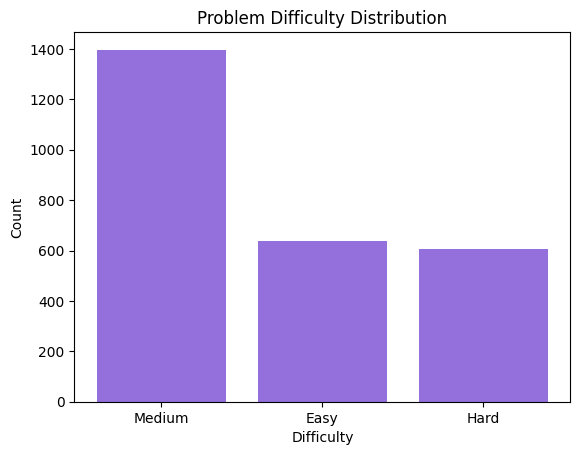

In [27]:
diff_pd = difficulty_counts.toPandas()
plt.bar(diff_pd['difficulty'], diff_pd['count'], color='mediumpurple')
plt.title('Problem Difficulty Distribution')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.show()


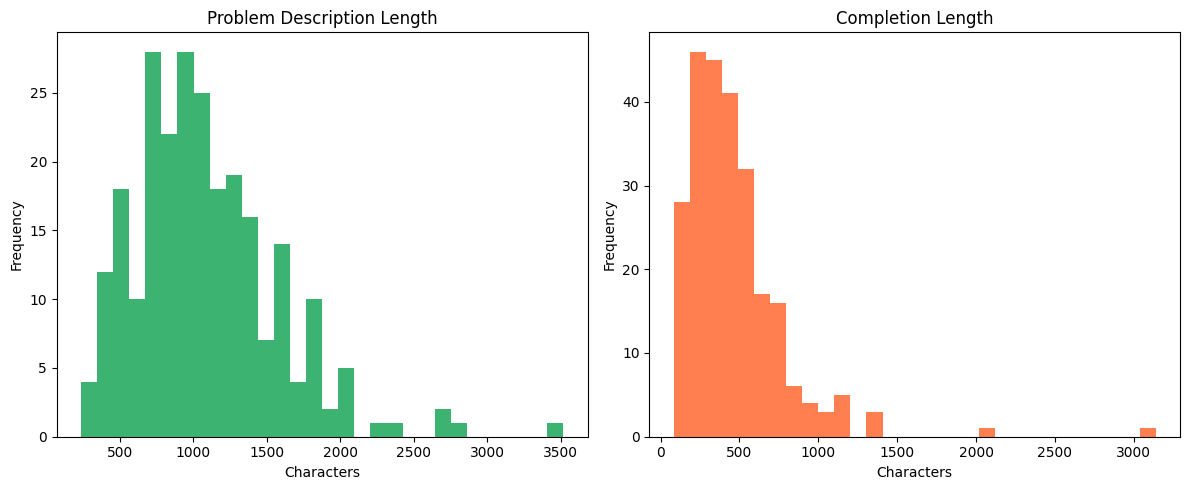

In [28]:
# Sample data to driver for plotting
sampled = df2.select("desc_length", "completion_length").sample(0.1, seed=42).toPandas()

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(sampled['desc_length'].dropna(), bins=30, color='mediumseagreen')
plt.title('Problem Description Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sampled['completion_length'].dropna(), bins=30, color='coral')
plt.title('Completion Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [29]:
# Explode tags array and count
tags_exploded = df.select(F.explode("tags").alias("tag"))
tag_counts = tags_exploded.groupBy("tag").count().orderBy(F.desc("count"))
tag_counts.show(10)


+-------------------+-----+
|                tag|count|
+-------------------+-----+
|              Array| 1619|
|             String|  675|
|         Hash Table|  540|
|Dynamic Programming|  511|
|               Math|  482|
|            Sorting|  405|
|             Greedy|  373|
| Depth-First Search|  252|
|      Binary Search|  246|
|             Matrix|  223|
+-------------------+-----+
only showing top 10 rows



+--------+-----+
|num_tags|count|
+--------+-----+
|       1|  204|
|       2|  685|
|       3|  802|
|       4|  539|
|       5|  261|
|       6|   94|
|       7|   42|
|       8|   13|
|      10|    1|
+--------+-----+



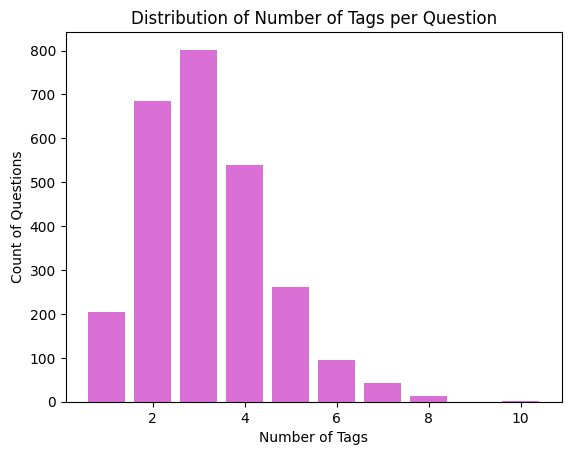

In [30]:
# Number of tags count per question
tag_counts_df = df.select(
    "question_id",
    F.size(F.col("tags")).alias("num_tags")
)

tag_counts_summary = tag_counts_df.groupBy("num_tags").count().orderBy("num_tags")
tag_counts_summary.show()

# Plot
tag_pd = tag_counts_summary.toPandas()
plt.bar(tag_pd['num_tags'], tag_pd['count'], color='orchid')
plt.title('Distribution of Number of Tags per Question')
plt.xlabel('Number of Tags')
plt.ylabel('Count of Questions')
plt.show()


+----------+-----+
|year_month|count|
+----------+-----+
|   2015-08|  675|
|   2018-05|   15|
|   2018-06|   15|
|   2018-07|   19|
|   2018-08|   14|
|   2018-09|   18|
|   2018-10|   15|
|   2018-11|   15|
|   2018-12|   20|
|   2019-01|   15|
+----------+-----+
only showing top 10 rows



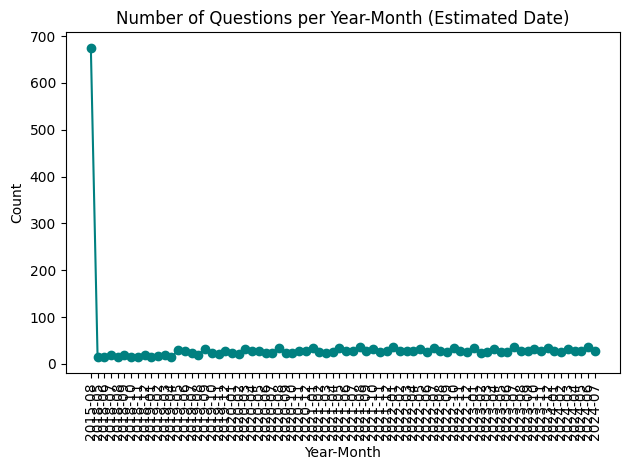

In [33]:
# Filter non-null estimated_date and group by year-month
date_df = df.filter(F.col("estimated_date").isNotNull())
date_counts = date_df.groupby(F.date_format("estimated_date", "yyyy-MM").alias("year_month")).count().orderBy("year_month")
date_counts.show(10)

# Plot
date_pd = date_counts.toPandas()
plt.plot(date_pd['year_month'], date_pd['count'], marker='o', color='teal')
plt.title('Number of Questions per Year-Month (Estimated Date)')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


+----------+------------------+------------------+
|difficulty|    avg_prompt_len|avg_completion_len|
+----------+------------------+------------------+
|      Easy| 1731.473354231975|284.00940438871476|
|      Hard|1746.9851485148515| 779.3019801980198|
|    Medium|1742.6141732283465|470.70007158196137|
+----------+------------------+------------------+



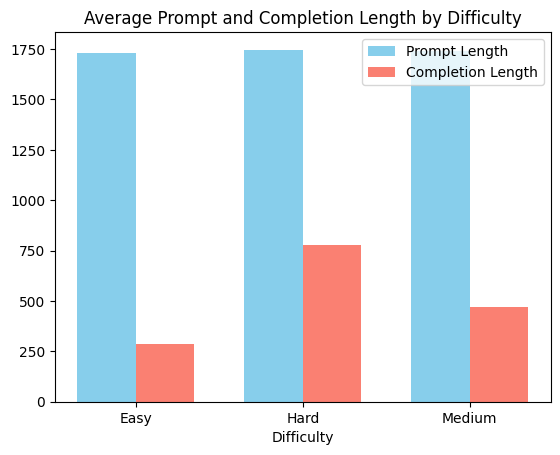

In [34]:
df_lengths = df.withColumn("prompt_length", F.length(F.col("prompt"))) \
               .withColumn("completion_length", F.length(F.col("completion")))

avg_lens = df_lengths.groupBy("difficulty") \
    .agg(
        F.avg("prompt_length").alias("avg_prompt_len"),
        F.avg("completion_length").alias("avg_completion_len")
    ).orderBy("difficulty")

avg_lens.show()

# Plot side-by-side bar chart
avg_pd = avg_lens.toPandas()
import numpy as np

x = np.arange(len(avg_pd))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, avg_pd['avg_prompt_len'], width, label='Prompt Length', color='skyblue')
rects2 = ax.bar(x + width/2, avg_pd['avg_completion_len'], width, label='Completion Length', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(avg_pd['difficulty'])
ax.set_xlabel('Difficulty')
ax.set_title('Average Prompt and Completion Length by Difficulty')
ax.legend()
plt.show()
